# A comparison of the static displacement of Mindlin-Reissner and Kirchhoff-Love plates under the effect of a uniformly distributed constant load

In this notebook, we explore the differences in calculating the same plate using the Kirchhoff-Love and Uflyand-Mindlin theories. The vertical displacements at the center of the plates are compared across varying thickness values and for two different side length ratios.

First we create a helper function that returns the value of the vertical displacement for a uniformly distributed load.

In [7]:
import numpy as np

from sigmaepsilon.solid.material import (
    MindlinPlateSection,
    KirchhoffPlateSection,
    ElasticityTensor,
    LinearElasticMaterial,
)
from sigmaepsilon.solid.fourier import (
    NavierPlate,
    LoadGroup,
    RectangleLoad,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix


def calculate_UZ(size: tuple, shape: tuple, model: str) -> float:
    # geometry
    length_X, length_Y, thickness = size

    # material
    young_modulus = 2890.0
    poisson_ratio = 0.2

    # material stiffness matrix
    hooke = elastic_stiffness_matrix(E=young_modulus, NU=poisson_ratio)
    stiffness = ElasticityTensor(hooke, tensorial=False)
    material = LinearElasticMaterial(stiffness=stiffness)
    section_type = MindlinPlateSection if model == "MR" else KirchhoffPlateSection
    section = section_type(
        layers=[
            section_type.Layer(material=material, thickness=thickness),
        ]
    )
    ABDS_matrix = section.elastic_stiffness_matrix()
    bending_stiffness, shear_stiffness = (
        np.ascontiguousarray(ABDS_matrix[:3, :3]),
        np.ascontiguousarray(ABDS_matrix[3:, 3:]),
    )
    if not model == "MR":
        shear_stiffness = None

    # uniform distributed load
    loads = LoadGroup(
        LC1=RectangleLoad([[0, 0], [length_X, length_Y]], [-0.1, 0, 0]),
    )
    loads.lock()

    # coordinates of the point of evaluation
    coords = np.array([[length_X / 2, length_Y / 2]], dtype=float)
    
    plate = NavierPlate(
        (length_X, length_Y), shape, D=bending_stiffness, S=shear_stiffness
    )
    results = plate.solve(loads, coords)

    # return results["LC1"][0, 0].values  # this would return the same value
    return results["LC1"].to_xarray().sel(index=0, component="UZ")

We create another helper function to calculate the normalized ratio of the results obtained for Kirchhoff-Love and Uflyand-Mindlin setups.

In [8]:
def generate_plot_data(size, thicknesses):
    Lx, Ly = size
    nx, ny = 20, 20
    absdiff = []
    for t in thicknesses:
        UZ_MR = calculate_UZ((Lx, Ly, t), (nx, ny), "MR")
        UZ_KL = calculate_UZ((Lx, Ly, t), (nx, ny), "KL")
        absdiff.append(UZ_MR / UZ_KL - 1)
    return absdiff

Finally, we prepare the data and plot the results using ``matplotlib``.

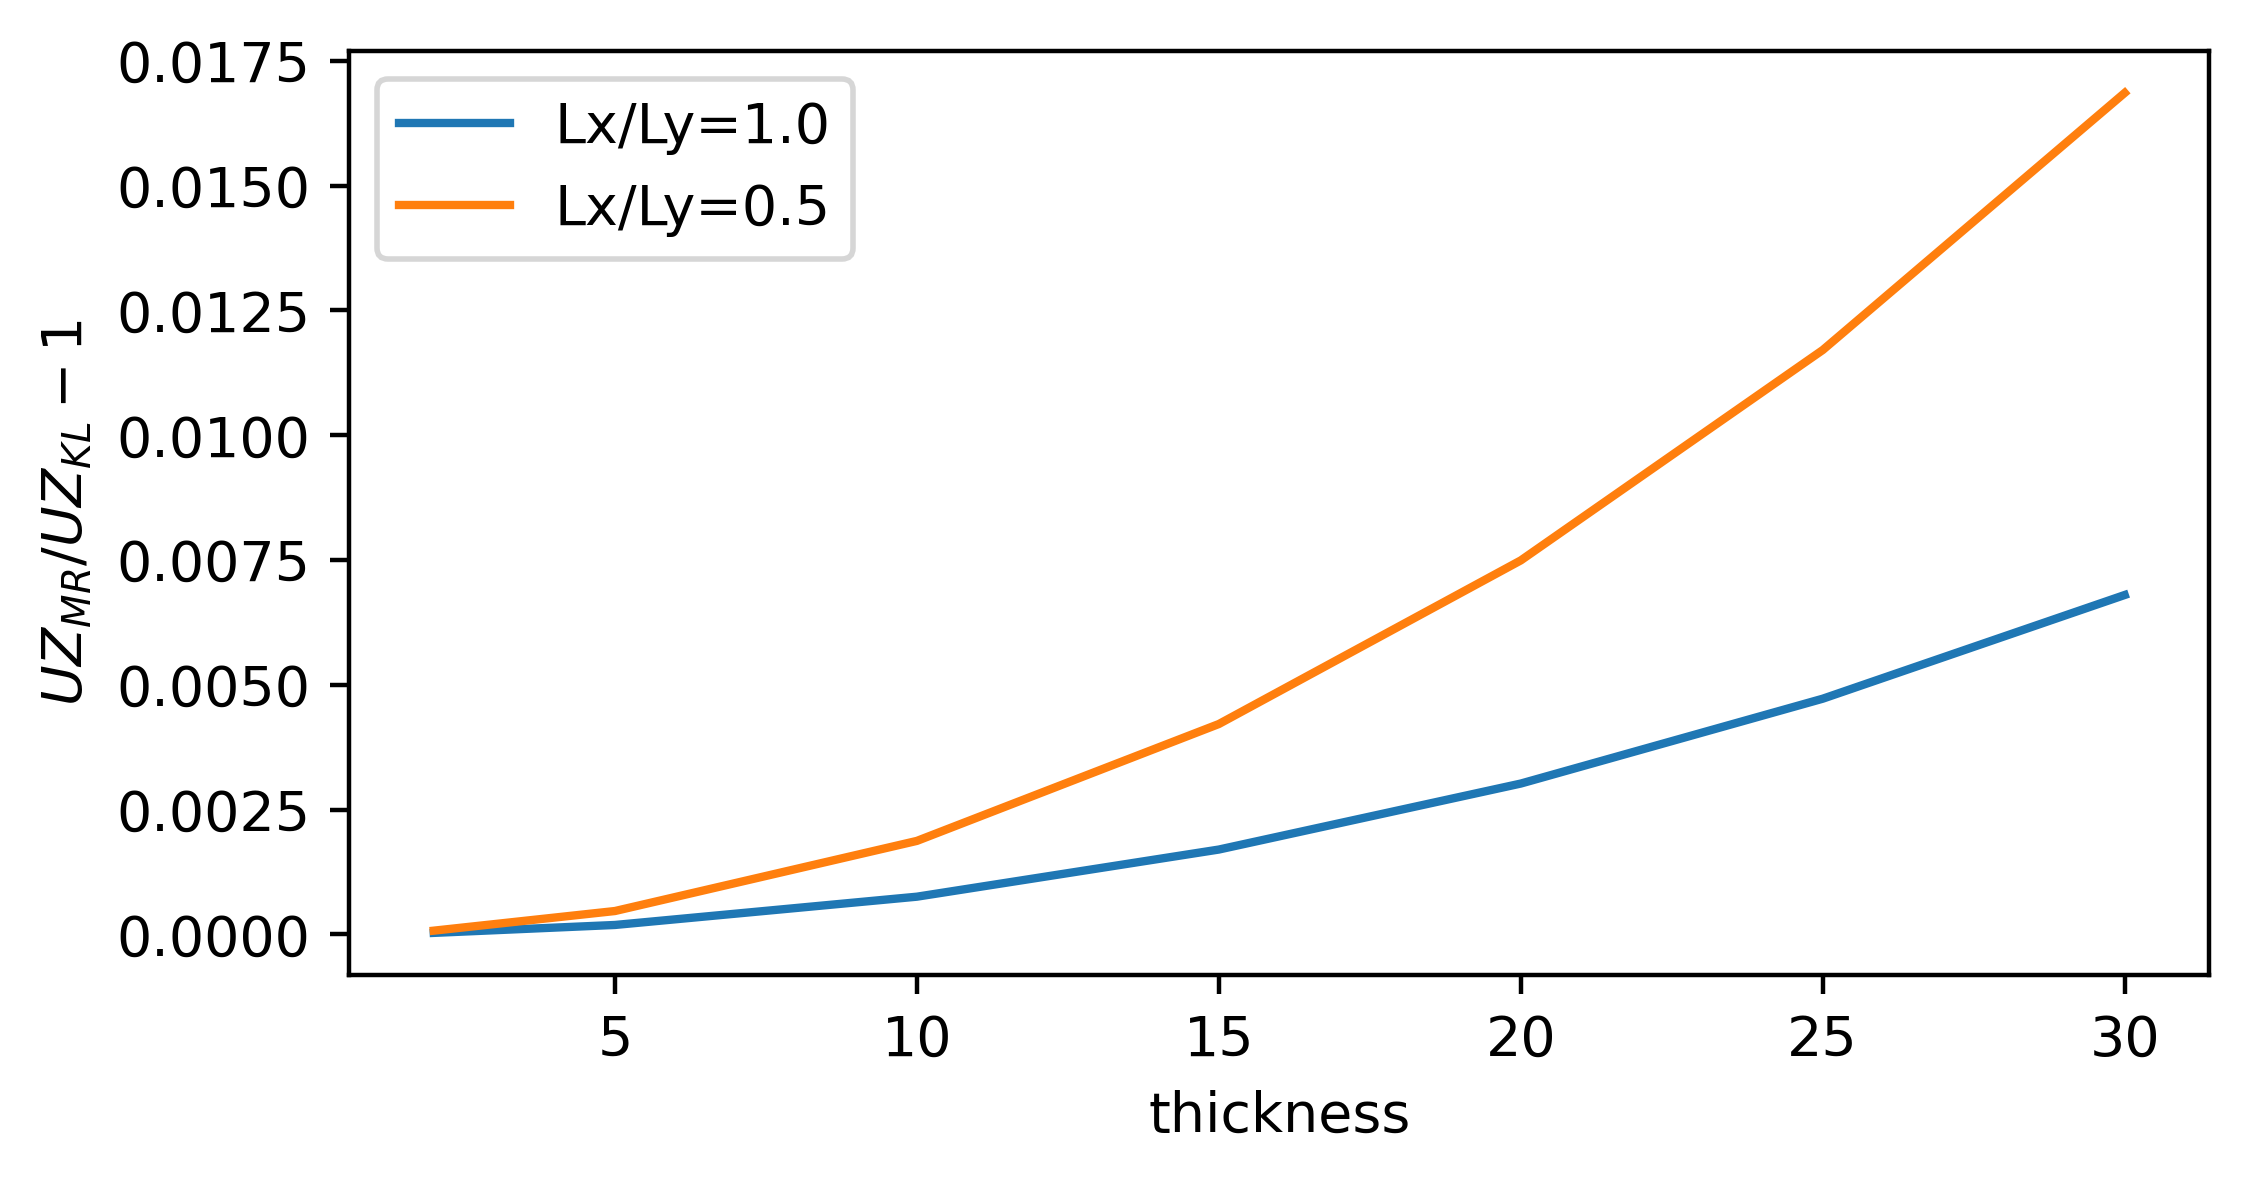

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(6, 3), dpi=400, sharex=True)

thicknesses = [2, 5, 10, 15, 20, 25, 30]

# calculate plot data for square plate
size = (800, 800)
width_ratio = size[0] / size[1]
absdiff = generate_plot_data(size, thicknesses)
axs.plot(thicknesses, absdiff, label="Lx/Ly={}".format(width_ratio))

# calculate plot data for rectangular plate
size = (400, 800)
width_ratio = size[0] / size[1]
absdiff = generate_plot_data(size, thicknesses)
axs.plot(thicknesses, absdiff, label="Lx/Ly={}".format(width_ratio))

axs.set_xlabel("thickness")
axs.set_ylabel("$UZ_{MR}/UZ_{KL} - 1 $")
axs.legend()

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
    }
)

The results show that:

* for small thicknesses, the results are about the same, regardless of the side ratio
* the differences are more significant for the rectangular plate